In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sl3

#Load Data From Database

In [3]:
dbfile = "../recipes.db"
conn = sl3.connect(dbfile)
cur = conn.cursor()

In [4]:
# First get the full data_frame including count_cluster
query = "SELECT recipe_id, average_rating, number_ratings FROM recipes"
recipe_df = pd.read_sql(query, conn)

#ingr_df.set_index(['new_description'],inplace=True)

# Take a look at the data:
print len(recipe_df), 'entries'
recipe_df.sort(['average_rating'],ascending=[0]).head(10)


100 entries


,recipe_id,average_rating,number_ratings
39,39,5.000000,1
85,85,5.000000,1
47,47,5.000000,1
51,51,5.000000,2
7,7,5.000000,4
31,31,5.000000,3
63,63,5.000000,1
64,64,5.000000,1
68,68,4.909091,11
46,46,4.900000,10


In [5]:
# First get the full data_frame including count_cluster
query = "SELECT recipe_id, new_description, proportion FROM new_ingredients"
new_ingr_df = pd.read_sql(query, conn)

#ingr_df.set_index(['new_description'],inplace=True)

# Take a look at the data:
print len(new_ingr_df), 'entries'
print new_ingr_df[new_ingr_df['recipe_id']==7]


840 entries
    recipe_id new_description  proportion
55          7           water    0.118779
56          7  garbonzo beans    0.481131
57          7            salt    0.009021
58          7           cumin    0.003157
59          7          tahini    0.238561
60          7     lemon juice    0.122287
61          7          garlic    0.012028
62          7         parsley    0.015035

[8 rows x 3 columns]


In [6]:
# First get the full data_frame including count_cluster
query = "SELECT new_description, mean_proportion, stddev_proportion, counts, norm_counts, count_cluster,\
 similarity_cluster, dissimilarity_cluster, final_selection FROM base_ingredients"
base_ingr_df = pd.read_sql(query, conn)

#ingr_df.set_index(['new_description'],inplace=True)

# Take a look at the data:
print len(base_ingr_df), 'entries'
base_ingr_df.sort(['counts'],ascending=[0]).head()

129 entries


,new_description,mean_proportion,stddev_proportion,counts,norm_counts,count_cluster,similarity_cluster,dissimilarity_cluster,final_selection
55,garlic,0.010577,0.007612,82,1.000000,2,1,1,1
54,garbonzo beans,0.598739,0.186017,76,0.926829,2,1,20,1
81,olive oil,0.043827,0.046208,69,0.841463,3,1,16,1
67,lemon juice,0.076270,0.056109,67,0.817073,3,1,19,1
102,salt,0.004098,0.003616,58,0.707317,4,1,9,1


# Simple Mean Method:

In [7]:
def get_norm_grams(df,use_mean):
    if use_mean:
        name = 'mean_proportion'
    else:
        name = 'proportion'
    prop_sum = df[name].sum(axis=1)
    df['grams_in_1kg'] = df[name] / prop_sum * 1000
    #df.drop([name],axis=1,inplace=True)
    return df

In [9]:
simple_results = base_ingr_df[base_ingr_df['final_selection']==1][['new_description', 'mean_proportion']]

simple_results = get_norm_grams(simple_results,1)

print simple_results

    new_description  mean_proportion  grams_in_1kg
16     black pepper         0.001551      1.592264
42            cumin         0.003360      3.449794
54   garbonzo beans         0.598739    614.796299
55           garlic         0.010577     10.860495
67      lemon juice         0.076270     78.315327
81        olive oil         0.043827     45.002192
87          paprika         0.001801      1.849080
89          parsley         0.012630     12.968670
102            salt         0.004098      4.207560
113          tahini         0.082664     84.881392
122           water         0.138366    142.076926

[11 rows x 3 columns]


In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

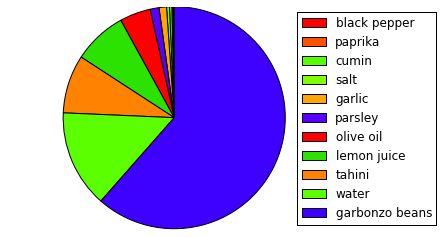

In [15]:
# The slices will be ordered and plotted counter-clockwise.
labels = simple_results.sort(['grams_in_1kg'],axis=0)['new_description'].as_matrix()
sizes = simple_results.sort(['grams_in_1kg'],axis=0)['grams_in_1kg'].as_matrix()
colors = base_ingr_df[base_ingr_df['final_selection']==1]['mean_proportion'].as_matrix()*4

my_norm = matplotlib.colors.Normalize(-1, 1) # maps your data to the range [0, 1]
my_cmap = matplotlib.cm.get_cmap('prism')

patches, texts = plt.pie(sizes, startangle=90,colors=my_cmap(colors))
plt.legend(patches, labels.tolist(), loc=5, bbox_to_anchor=(1.3,.5))

plt.axis('equal')
plt.show()

In [10]:

print simple_results.sort(['grams_in_1kg'],ascending=[0])

    new_description  mean_proportion  grams_in_1kg
54   garbonzo beans         0.598739    614.796299
122           water         0.138366    142.076926
113          tahini         0.082664     84.881392
67      lemon juice         0.076270     78.315327
81        olive oil         0.043827     45.002192
89          parsley         0.012630     12.968670
55           garlic         0.010577     10.860495
102            salt         0.004098      4.207560
42            cumin         0.003360      3.449794
87          paprika         0.001801      1.849080
16     black pepper         0.001551      1.592264

[11 rows x 3 columns]


Actual Recipes for comparison:

In [12]:
#I manually picked out some high rated recipes to look at their proportions for comparison

print get_norm_grams(new_ingr_df[new_ingr_df['recipe_id']==7],0).sort(['grams_in_1kg'],ascending=[0])
print get_norm_grams(new_ingr_df[new_ingr_df['recipe_id']==46],0).sort(['grams_in_1kg'],ascending=[0])
print get_norm_grams(new_ingr_df[new_ingr_df['recipe_id']==31],0).sort(['grams_in_1kg'],ascending=[0])

    recipe_id new_description  proportion  grams_in_1kg
56          7  garbonzo beans    0.481131    481.130657
59          7          tahini    0.238561    238.560617
60          7     lemon juice    0.122287    122.287375
55          7           water    0.118779    118.779131
62          7         parsley    0.015035     15.035333
61          7          garlic    0.012028     12.028266
57          7            salt    0.009021      9.021200
58          7           cumin    0.003157      3.157420

[8 rows x 4 columns]
     recipe_id new_description  proportion  grams_in_1kg
375         46  garbonzo beans    0.623760    623.759675
381         46      lime juice    0.137004    137.004357
374         46       olive oil    0.122524    122.524222
377         46          tahini    0.066831     66.831394
373         46           water    0.032937     32.936739
379         46          garlic    0.006683      6.683139
378         46         paprika    0.005081      5.081042
380         46  ca

#Simple Mean Conclusion
Based on a shallow comparison by eye with 3 highly rated recipes, the Simple Mean recipe seems reasonable. There are no obvious misbalances.

Next we will take a weighted average of ingredient proportions weighted by a user rating score. 

The 3rd step will be calculating a jaccard similarity of the selected ingredient set with all input recipes and weighting the proportions both based on user ratings and similarity to the selected recipe.

#User Rating Weighted Average Method:

#Similarity + User Rating Weighted Method: